# Импорт

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import PIL.Image as Image

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

from LookGenerator.datasets.utils import load_image
from LookGenerator.datasets.person_segmentation_dataset import PersonSegmentationDataset, PersonSegmentationDatasetMultichannel, PersonSegmentationDatasetMultichannel2
from LookGenerator.networks.segmentation import UNet
from LookGenerator.networks.trainer import Trainer
from LookGenerator.networks.losses import FocalLossMulti
from LookGenerator.networks.utils import load_model
import LookGenerator.datasets.transforms as custom_transforms
from LookGenerator.networks_training.utils import check_path_and_creat
import albumentations

# Загрузка данных

In [2]:
transform_train = albumentations.Compose([
        albumentations.Resize(height=256, width=192),
        albumentations.RandomBrightnessContrast(brightness_limit=(0.1,0.3), contrast_limit=(0.2,0.7), p =0.2),
        albumentations.Equalize(p = 0.2),
        albumentations.GaussNoise(p = 0.2),
        albumentations.Affine(translate_percent=0.1, scale=(0.8, 1), rotate=(-90,90), p=0.75),
        albumentations.Normalize(mean = (0.5, 0.5, 0.5), std = (0.25, 0.25, 0.25)),
    ])

transform_valid = albumentations.Compose([
        albumentations.Resize(height=256, width=192),
        albumentations.Normalize(mean = (0.5, 0.5, 0.5), std = (0.25, 0.25, 0.25)),
    ])

In [2]:
# transform_input = transforms.Compose([
#     transforms.Resize((256, 192)),
#     transforms.RandomAffine(scale=(0.8, 1), degrees=(-90,90), fill = 0.9),
#     # transforms.ColorJitter(brightness=(0.5, 1), contrast=(0.4,1),  hue=(0, 0.3)),
#     transforms.Normalize(
#         mean=[0.5, 0.5, 0.5],
#         std=[0.25, 0.25, 0.25]
#     )
# ])
#
# transform_output = transforms.Compose([
#     transforms.Resize((256, 192)),
#     transforms.RandomAffine(scale=(0.8, 1), degrees=(-90,90), fill = 0),
#     custom_transforms.MinMaxScale(),
#     custom_transforms.ThresholdTransform(threshold=0.5)
# ])

In [3]:
batch_size_train = 96
batch_size_val = 64
pin_memory = True
num_workers = 12

In [4]:
train_dataset = PersonSegmentationDatasetMultichannel2(r'C:\Users\DenisovDmitrii\Desktop\12channels\trainData',
    #r"C:\Users\DenisovDmitrii\Desktop\trainData",
                                                      augment=transform_train)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True, pin_memory=pin_memory, num_workers=num_workers)

(len(train_dataset), len(train_dataloader))

(11647, 122)

In [5]:
val_dataset = PersonSegmentationDatasetMultichannel2(r'C:\Users\DenisovDmitrii\Desktop\12channels\valData',
    #r"C:\Users\DenisovDmitrii\Desktop\trainData",
                                                      augment=transform_train)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size_val, shuffle=False, pin_memory=pin_memory, num_workers=num_workers)

(len(val_dataset), len(val_dataloader))

(2032, 32)

In [12]:
# train_dataset = PersonSegmentationDatasetMultichannel(r'C:\Users\DenisovDmitrii\Desktop\12channels\trainData',
#     #r"C:\Users\DenisovDmitrii\Desktop\trainData",
#                                                       transform_input=transform_input,
#                                                       transform_output=transform_output)
# train_dataloader = DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True, pin_memory=pin_memory, num_workers=num_workers)
# (len(train_dataset), len(train_dataloader))

In [13]:
# val_dataset = PersonSegmentationDatasetMultichannel(r'C:\Users\DenisovDmitrii\Desktop\12channels\valData',
#     #r"C:\Users\DenisovDmitrii\Desktop\trainData",
#                                                       transform_input=transform_input,
#                                                       transform_output=transform_output
#                                                     )#r"C:\Users\DenisovDmitrii\Desktop\valData")
# val_dataloader = DataLoader(val_dataset, batch_size=batch_size_val, shuffle=False, pin_memory=pin_memory, num_workers=num_workers)
# (len(val_dataset), len(val_dataloader))

Test load train_dataloader. and val.

torch.Size([64, 3, 256, 192])
torch.Size([64, 12, 256, 192])
False


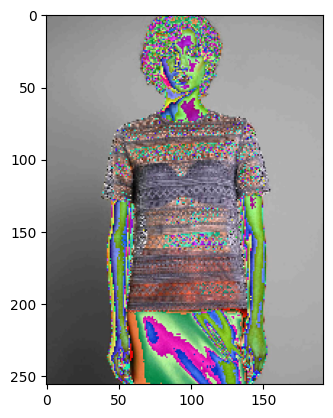

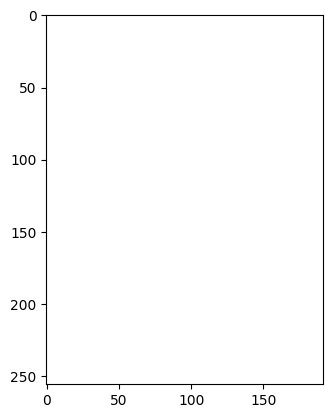

In [6]:
for X, y in train_dataloader:
    print(X.shape)
    print(y.shape)
    print(X.requires_grad)
    X = transforms.ToPILImage() (X[0])
    X = np.array(X)
    plt.imshow(X)
    plt.show()
    y = transforms.ToPILImage()(y[0,11])
    y = np.array(y)
    plt.imshow(y, cmap='binary')
    plt.show()

    break

# Обучение модели

torch.Size([32, 3, 256, 192])
torch.Size([32, 12, 256, 192])
False


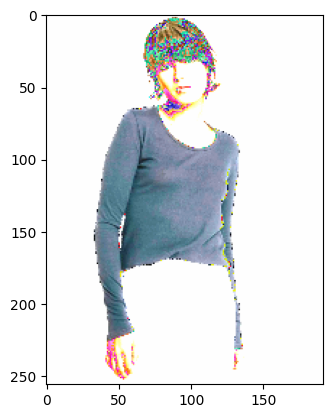

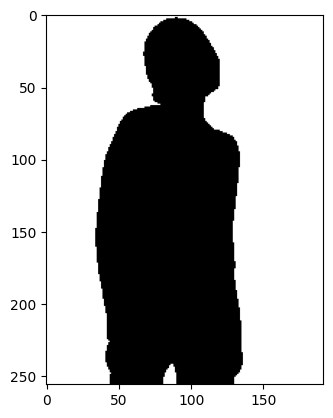

In [7]:
for X, y in val_dataloader:
    print(X.shape)
    print(y.shape)
    print(X.requires_grad)
    X = transforms.ToPILImage() (X[0])
    X = np.array(X)
    plt.imshow(X)
    plt.show()
    y = transforms.ToPILImage()(y[0,0])
    y = np.array(y)
    plt.imshow(y, cmap='binary')
    plt.show()

    break

Метки классов на изображении:

1. Левое лицо                       248,251,14
2. Правое лицо                      251,235,25
3. Туловище                         20,80,194
4. Внешняя верхняя левая рука       190,189,96
5. Внешняя верхняя правая рука      215,187,88
6. Внешняя нижняя левая рука        252,206,48
7. Внешняя нижняя правая рука       250,220,36
8. Внутренняя верхняя левая рука    145,191,116
9. Внутренняя верхняя правая рука   170,190,105
10. Внетренняя нижняя левая рука     228,191,74
11. Внутренняя нижняя правая рука    240,198,60
12. Левая кисть                      8,110,221
13. Правая кисть                     4,98,224
14. Левая нога                       22,173,184
15. Правая нога                      6,166,198

In [6]:
model = UNet(in_channels=3, out_channels = 12, features=(20, 40, 80, 160, 320, 640),
             final_activation=nn.Softmax(dim=1))
#model = load_model(model, r'C:\Users\DenisovDmitrii\OneDrive - ITMO UNIVERSITY\peopleDetector\segmentationMulty\weights\testMulty_out_11\epoch_29.pt')
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
criterion = FocalLossMulti(device=device)
print(device)

cuda


In [7]:
save_directory = r'C:\Users\DenisovDmitrii\OneDrive - ITMO UNIVERSITY\peopleDetector\segmentationMulty\weights\testMulty_out_12_6features_20to640'
check_path_and_creat(save_directory)

True

In [8]:
torch.backends.cuda.matmul.allow_tf32 = False
torch.backends.cudnn.benchmark = True

In [9]:
trainer = Trainer(
    model_=model, optimizer=optimizer, criterion=criterion,
    device=device, save_directory=save_directory, save_step=1, verbose=True
)

In [11]:
epoch_num=40

In [12]:
trainer.train(train_dataloader=train_dataloader, val_dataloader=val_dataloader, epoch_num=epoch_num)

start time 05-06-2023 18:25


100%|██████████| 122/122 [02:10<00:00,  1.07s/it]


Epoch 0 of 39, train loss: 0.00125
Epoch end time 05-06-2023 18:27


100%|██████████| 32/32 [00:25<00:00,  1.27it/s]


Epoch 0 of 39, val loss: 0.00061
Epoch end time 05-06-2023 18:27


100%|██████████| 122/122 [01:43<00:00,  1.18it/s]


Epoch 1 of 39, train loss: 0.00049
Epoch end time 05-06-2023 18:29


100%|██████████| 32/32 [00:20<00:00,  1.57it/s]


Epoch 1 of 39, val loss: 0.00045
Epoch end time 05-06-2023 18:30


100%|██████████| 122/122 [01:41<00:00,  1.20it/s]


Epoch 2 of 39, train loss: 0.00038
Epoch end time 05-06-2023 18:31


100%|██████████| 32/32 [00:18<00:00,  1.73it/s]


Epoch 2 of 39, val loss: 0.00042
Epoch end time 05-06-2023 18:32


100%|██████████| 122/122 [01:43<00:00,  1.18it/s]


Epoch 3 of 39, train loss: 0.00032
Epoch end time 05-06-2023 18:33


100%|██████████| 32/32 [00:17<00:00,  1.81it/s]


Epoch 3 of 39, val loss: 0.00052
Epoch end time 05-06-2023 18:34


100%|██████████| 122/122 [01:39<00:00,  1.22it/s]


Epoch 4 of 39, train loss: 0.00024
Epoch end time 05-06-2023 18:35


100%|██████████| 32/32 [00:18<00:00,  1.75it/s]


Epoch 4 of 39, val loss: 0.00031
Epoch end time 05-06-2023 18:36


100%|██████████| 122/122 [01:39<00:00,  1.22it/s]


Epoch 5 of 39, train loss: 0.00024
Epoch end time 05-06-2023 18:37


100%|██████████| 32/32 [00:17<00:00,  1.87it/s]


Epoch 5 of 39, val loss: 0.00022
Epoch end time 05-06-2023 18:37


100%|██████████| 122/122 [01:38<00:00,  1.23it/s]


Epoch 6 of 39, train loss: 0.00019
Epoch end time 05-06-2023 18:39


100%|██████████| 32/32 [00:16<00:00,  1.90it/s]


Epoch 6 of 39, val loss: 0.00020
Epoch end time 05-06-2023 18:39


100%|██████████| 122/122 [01:39<00:00,  1.23it/s]


Epoch 7 of 39, train loss: 0.00019
Epoch end time 05-06-2023 18:41


100%|██████████| 32/32 [00:16<00:00,  1.90it/s]


Epoch 7 of 39, val loss: 0.00075
Epoch end time 05-06-2023 18:41


100%|██████████| 122/122 [01:39<00:00,  1.23it/s]


Epoch 8 of 39, train loss: 0.00017
Epoch end time 05-06-2023 18:43


100%|██████████| 32/32 [00:16<00:00,  1.91it/s]


Epoch 8 of 39, val loss: 0.00019
Epoch end time 05-06-2023 18:43


100%|██████████| 122/122 [01:37<00:00,  1.26it/s]


Epoch 9 of 39, train loss: 0.00015
Epoch end time 05-06-2023 18:45


100%|██████████| 32/32 [00:16<00:00,  1.91it/s]


Epoch 9 of 39, val loss: 0.00016
Epoch end time 05-06-2023 18:45


100%|██████████| 122/122 [01:37<00:00,  1.25it/s]


Epoch 10 of 39, train loss: 0.00013
Epoch end time 05-06-2023 18:47


100%|██████████| 32/32 [00:16<00:00,  1.89it/s]


Epoch 10 of 39, val loss: 0.00016
Epoch end time 05-06-2023 18:47


100%|██████████| 122/122 [01:37<00:00,  1.25it/s]


Epoch 11 of 39, train loss: 0.00012
Epoch end time 05-06-2023 18:49


100%|██████████| 32/32 [00:16<00:00,  1.89it/s]


Epoch 11 of 39, val loss: 0.00013
Epoch end time 05-06-2023 18:49


100%|██████████| 122/122 [01:39<00:00,  1.23it/s]


Epoch 12 of 39, train loss: 0.00012
Epoch end time 05-06-2023 18:51


100%|██████████| 32/32 [00:17<00:00,  1.87it/s]


Epoch 12 of 39, val loss: 0.00016
Epoch end time 05-06-2023 18:51


100%|██████████| 122/122 [01:39<00:00,  1.23it/s]


Epoch 13 of 39, train loss: 0.00014
Epoch end time 05-06-2023 18:53


100%|██████████| 32/32 [00:16<00:00,  1.90it/s]


Epoch 13 of 39, val loss: 0.00015
Epoch end time 05-06-2023 18:53


100%|██████████| 122/122 [01:37<00:00,  1.25it/s]


Epoch 14 of 39, train loss: 0.00013
Epoch end time 05-06-2023 18:55


100%|██████████| 32/32 [00:16<00:00,  1.92it/s]


Epoch 14 of 39, val loss: 0.00013
Epoch end time 05-06-2023 18:55


100%|██████████| 122/122 [01:37<00:00,  1.26it/s]


Epoch 15 of 39, train loss: 0.00012
Epoch end time 05-06-2023 18:56


100%|██████████| 32/32 [00:17<00:00,  1.87it/s]


Epoch 15 of 39, val loss: 0.00014
Epoch end time 05-06-2023 18:57


100%|██████████| 122/122 [01:39<00:00,  1.23it/s]


Epoch 16 of 39, train loss: 0.00015
Epoch end time 05-06-2023 18:58


100%|██████████| 32/32 [00:17<00:00,  1.87it/s]


Epoch 16 of 39, val loss: 0.00017
Epoch end time 05-06-2023 18:59


100%|██████████| 122/122 [01:43<00:00,  1.18it/s]


Epoch 17 of 39, train loss: 0.00013
Epoch end time 05-06-2023 19:00


100%|██████████| 32/32 [00:18<00:00,  1.77it/s]


Epoch 17 of 39, val loss: 0.00024
Epoch end time 05-06-2023 19:01


100%|██████████| 122/122 [01:44<00:00,  1.16it/s]


Epoch 18 of 39, train loss: 0.00011
Epoch end time 05-06-2023 19:02


100%|██████████| 32/32 [00:19<00:00,  1.61it/s]


Epoch 18 of 39, val loss: 0.00013
Epoch end time 05-06-2023 19:03


100%|██████████| 122/122 [01:43<00:00,  1.18it/s]


Epoch 19 of 39, train loss: 0.00011
Epoch end time 05-06-2023 19:05


100%|██████████| 32/32 [00:18<00:00,  1.68it/s]


Epoch 19 of 39, val loss: 0.00012
Epoch end time 05-06-2023 19:05


100%|██████████| 122/122 [01:42<00:00,  1.19it/s]


Epoch 20 of 39, train loss: 0.00010
Epoch end time 05-06-2023 19:07


100%|██████████| 32/32 [00:18<00:00,  1.71it/s]


Epoch 20 of 39, val loss: 0.00013
Epoch end time 05-06-2023 19:07


100%|██████████| 122/122 [01:41<00:00,  1.20it/s]


Epoch 21 of 39, train loss: 0.00010
Epoch end time 05-06-2023 19:09


100%|██████████| 32/32 [00:17<00:00,  1.85it/s]


Epoch 21 of 39, val loss: 0.00009
Epoch end time 05-06-2023 19:09


100%|██████████| 122/122 [01:39<00:00,  1.23it/s]


Epoch 22 of 39, train loss: 0.00009
Epoch end time 05-06-2023 19:11


100%|██████████| 32/32 [00:17<00:00,  1.87it/s]


Epoch 22 of 39, val loss: 0.00011
Epoch end time 05-06-2023 19:11


100%|██████████| 122/122 [01:38<00:00,  1.23it/s]


Epoch 23 of 39, train loss: 0.00009
Epoch end time 05-06-2023 19:12


100%|██████████| 32/32 [00:17<00:00,  1.86it/s]


Epoch 23 of 39, val loss: 0.00010
Epoch end time 05-06-2023 19:13


100%|██████████| 122/122 [01:38<00:00,  1.24it/s]


Epoch 24 of 39, train loss: 0.00008
Epoch end time 05-06-2023 19:14


100%|██████████| 32/32 [00:17<00:00,  1.84it/s]


Epoch 24 of 39, val loss: 0.00011
Epoch end time 05-06-2023 19:15


100%|██████████| 122/122 [01:39<00:00,  1.23it/s]


Epoch 25 of 39, train loss: 0.00009
Epoch end time 05-06-2023 19:16


100%|██████████| 32/32 [00:17<00:00,  1.84it/s]


Epoch 25 of 39, val loss: 0.00010
Epoch end time 05-06-2023 19:17


100%|██████████| 122/122 [01:37<00:00,  1.25it/s]


Epoch 26 of 39, train loss: 0.00010
Epoch end time 05-06-2023 19:18


100%|██████████| 32/32 [00:16<00:00,  1.91it/s]


Epoch 26 of 39, val loss: 0.00011
Epoch end time 05-06-2023 19:19


100%|██████████| 122/122 [01:37<00:00,  1.26it/s]


Epoch 27 of 39, train loss: 0.00009
Epoch end time 05-06-2023 19:20


100%|██████████| 32/32 [00:16<00:00,  1.91it/s]


Epoch 27 of 39, val loss: 0.00014
Epoch end time 05-06-2023 19:20


100%|██████████| 122/122 [01:36<00:00,  1.26it/s]


Epoch 28 of 39, train loss: 0.00010
Epoch end time 05-06-2023 19:22


100%|██████████| 32/32 [00:16<00:00,  1.92it/s]


Epoch 28 of 39, val loss: 0.00015
Epoch end time 05-06-2023 19:22


100%|██████████| 122/122 [01:37<00:00,  1.25it/s]


Epoch 29 of 39, train loss: 0.00009
Epoch end time 05-06-2023 19:24


100%|██████████| 32/32 [00:16<00:00,  1.90it/s]


Epoch 29 of 39, val loss: 0.00009
Epoch end time 05-06-2023 19:24


100%|██████████| 122/122 [01:37<00:00,  1.25it/s]


Epoch 30 of 39, train loss: 0.00008
Epoch end time 05-06-2023 19:26


100%|██████████| 32/32 [00:16<00:00,  1.89it/s]


Epoch 30 of 39, val loss: 0.00009
Epoch end time 05-06-2023 19:26


100%|██████████| 122/122 [01:39<00:00,  1.23it/s]


Epoch 31 of 39, train loss: 0.00007
Epoch end time 05-06-2023 19:28


100%|██████████| 32/32 [00:16<00:00,  1.92it/s]


Epoch 31 of 39, val loss: 0.00009
Epoch end time 05-06-2023 19:28


100%|██████████| 122/122 [01:38<00:00,  1.24it/s]


Epoch 32 of 39, train loss: 0.00008
Epoch end time 05-06-2023 19:30


100%|██████████| 32/32 [00:16<00:00,  1.90it/s]


Epoch 32 of 39, val loss: 0.00012
Epoch end time 05-06-2023 19:30


100%|██████████| 122/122 [01:37<00:00,  1.25it/s]


Epoch 33 of 39, train loss: 0.00009
Epoch end time 05-06-2023 19:32


100%|██████████| 32/32 [00:16<00:00,  1.91it/s]


Epoch 33 of 39, val loss: 0.00017
Epoch end time 05-06-2023 19:32


100%|██████████| 122/122 [01:38<00:00,  1.24it/s]


Epoch 34 of 39, train loss: 0.00011
Epoch end time 05-06-2023 19:34


100%|██████████| 32/32 [00:17<00:00,  1.87it/s]


Epoch 34 of 39, val loss: 0.00024
Epoch end time 05-06-2023 19:34


100%|██████████| 122/122 [01:38<00:00,  1.24it/s]


Epoch 35 of 39, train loss: 0.00009
Epoch end time 05-06-2023 19:35


100%|██████████| 32/32 [00:16<00:00,  1.91it/s]


Epoch 35 of 39, val loss: 0.00010
Epoch end time 05-06-2023 19:36


100%|██████████| 122/122 [01:36<00:00,  1.26it/s]


Epoch 36 of 39, train loss: 0.00009
Epoch end time 05-06-2023 19:37


100%|██████████| 32/32 [00:16<00:00,  1.93it/s]


Epoch 36 of 39, val loss: 0.00016
Epoch end time 05-06-2023 19:38


100%|██████████| 122/122 [01:37<00:00,  1.25it/s]


Epoch 37 of 39, train loss: 0.00008
Epoch end time 05-06-2023 19:39


100%|██████████| 32/32 [00:16<00:00,  1.90it/s]


Epoch 37 of 39, val loss: 0.00010
Epoch end time 05-06-2023 19:40


100%|██████████| 122/122 [01:38<00:00,  1.24it/s]


Epoch 38 of 39, train loss: 0.00008
Epoch end time 05-06-2023 19:41


100%|██████████| 32/32 [00:16<00:00,  1.92it/s]


Epoch 38 of 39, val loss: 0.00009
Epoch end time 05-06-2023 19:41


100%|██████████| 122/122 [01:38<00:00,  1.24it/s]


Epoch 39 of 39, train loss: 0.00012
Epoch end time 05-06-2023 19:43


100%|██████████| 32/32 [00:16<00:00,  1.92it/s]

Epoch 39 of 39, val loss: 0.00013
Epoch end time 05-06-2023 19:43
end time 05-06-2023 19:43
delta 1:18:32.839158


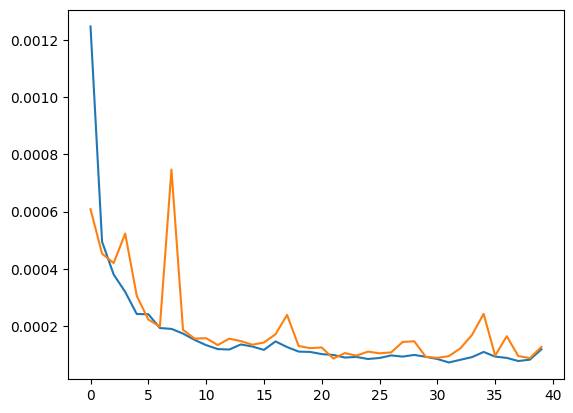

In [17]:
trainer.draw_history_plots()

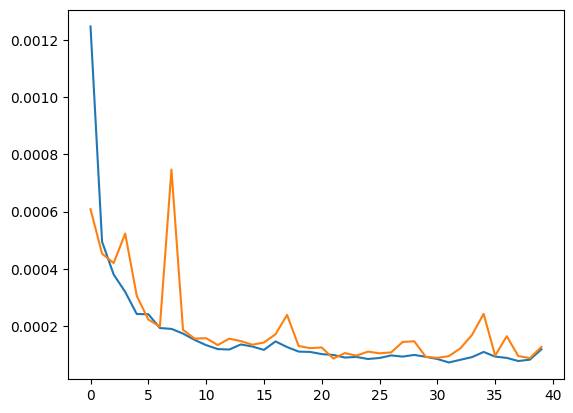

In [14]:
trainer.save_history_plots(save_directory)

In [15]:
trainer.create_readme(save_directory)

In [16]:
from torchsummary import summary
summary(model.to('cuda'), (3, 256, 192))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 20, 256, 192]             560
       BatchNorm2d-2         [-1, 20, 256, 192]              40
         LeakyReLU-3         [-1, 20, 256, 192]               0
         LeakyReLU-4         [-1, 20, 256, 192]               0
           Conv3x3-5         [-1, 20, 256, 192]               0
            Conv2d-6         [-1, 20, 256, 192]           3,620
       BatchNorm2d-7         [-1, 20, 256, 192]              40
           Conv3x3-8         [-1, 20, 256, 192]               0
         LeakyReLU-9         [-1, 20, 256, 192]               0
        LeakyReLU-10         [-1, 20, 256, 192]               0
          Conv5x5-11         [-1, 20, 256, 192]               0
        MaxPool2d-12          [-1, 20, 128, 96]               0
           Conv2d-13          [-1, 40, 128, 96]           7,240
      BatchNorm2d-14          [-1, 40, 

In [ ]:
model = load_model(model, r'C:\Users\Даша\PycharmProjects\SMBackEnd\LookGenerator\weights\unet_epoch_0_0.0161572862694324.pt')
model.eval()

In [ ]:
test_dir = r""
test_folder = ""
save_masks_dir = r""
list_files = os.listdir(test_dir)
images = [file.split('.') for file in list_files]

In [ ]:
for image in images:
    print(image)
    img = load_image(test_dir, test_folder, image, '.jpg')
    img_to_model = prepare_image_for_model(img, transform_input)
    modelled = model(img_to_model)
    mask = to_array_from_model_bin(modelled)

    plt.figure(figsize=(18, 6))
    plt.subplot(1,2,0)
    plt.imshow(img)
    plt.subplot(1,2,1)
    plt.imshow(mask)

    Image.fromarray(mask, 'L').save(save_masks_dir + image + '.png')
